### --- Step 1: Setup and Imports ---


In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import hopsworks
import exclude.key

# Hopsworks
HOPSWORKS_API_KEY = exclude.key.HOPSWORKS_API_KEY
FEATURE_GROUP_NAME = "bars_near_london_bridge"
FEATURE_GROUP_VERSION = 3
FEATURE_VIEW_VERSION = 4

# Connect to Hopsworks
project = hopsworks.login(api_key_value=HOPSWORKS_API_KEY)
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/25749
Connected. Call `.close()` to terminate connection gracefully.


### --- Step 2: Load Data from the Feature group ---


In [27]:
# Retrieve feature groups.
fg = fs.get_feature_group(
    name=FEATURE_GROUP_NAME, 
    version=FEATURE_GROUP_VERSION,
)

# Select features for training datasets
df = fg.read()
df.head(5)

2024-06-07 11:34:06,949 WARNING: DeprecationWarning: DatetimeTZBlock is deprecated and will be removed in a future version. Use public APIs instead.

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.41s) 


,venue_name,venue_address,day,hour,busyness,busyness_numeric,popularity,last_updated
0,Nine Lives,"8 Holyrood St, London SE1 2EL, United Kingdom",Saturday,14,Closed,0,0.438710,2024-06-07 11:16:35.099076+00:00
1,"The Hung Drawn & Quartered, EC3","26-27 Great Tower St, London EC3R 5AQ, United ...",Saturday,7,Closed,0,0.716129,2024-06-07 11:16:35.099076+00:00
2,El Vino London Bridge,"5a More London Pl, London SE1 2BY, United Kingdom",Tuesday,23,Closed,0,0.625806,2024-06-07 11:16:35.099076+00:00
3,"The Bridge Tap, London","32 Borough High St, London SE1 1XU, United Kin...",Tuesday,6,Closed,0,0.858065,2024-06-07 11:16:35.099076+00:00
4,El Vino London Bridge,"5a More London Pl, London SE1 2BY, United Kingdom",Wednesday,15,Average,3,0.625806,2024-06-07 11:16:35.099076+00:00


### --- Step 3: Process the Data ---

In [28]:
# Load transformation functions from the feature store
min_max_scaler = fs.get_transformation_function(name="min_max_scaler")
label_encoder = fs.get_transformation_function(name="label_encoder")

# Define numerical and categorical features
numerical_features = ["hour"]
categorical_features = ["day"]

# Map features to transformation functions
transformation_functions = {}
for feature in numerical_features:
    transformation_functions[feature] = min_max_scaler
for feature in categorical_features:
    transformation_functions[feature] = label_encoder

df.head(5)

,venue_name,venue_address,day,hour,busyness,busyness_numeric,popularity,last_updated
0,Nine Lives,"8 Holyrood St, London SE1 2EL, United Kingdom",Saturday,14,Closed,0,0.438710,2024-06-07 11:16:35.099076+00:00
1,"The Hung Drawn & Quartered, EC3","26-27 Great Tower St, London EC3R 5AQ, United ...",Saturday,7,Closed,0,0.716129,2024-06-07 11:16:35.099076+00:00
2,El Vino London Bridge,"5a More London Pl, London SE1 2BY, United Kingdom",Tuesday,23,Closed,0,0.625806,2024-06-07 11:16:35.099076+00:00
3,"The Bridge Tap, London","32 Borough High St, London SE1 1XU, United Kin...",Tuesday,6,Closed,0,0.858065,2024-06-07 11:16:35.099076+00:00
4,El Vino London Bridge,"5a More London Pl, London SE1 2BY, United Kingdom",Wednesday,15,Average,3,0.625806,2024-06-07 11:16:35.099076+00:00


### --- Step 4: Create the feature view ---

In [29]:
query = fg.select_except(['busyness','venue_address','venue_name','last_updated','busyness'])

feature_view = fs.get_or_create_feature_view(
    name='busyness_feature_view',
    version=FEATURE_VIEW_VERSION,
    query=query,
    labels=["busyness_numeric"],
    transformation_functions=transformation_functions,
)

# if the featureview is already created just retrieve it 
# feature_view = fs.get_feature_view(name='busyness_feature_view', version=FEATURE_VIEW_VERSION)


Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/25749/fs/25669/fv/busyness_feature_view/version/4


### --- Step 5: Create the training dataset ---

In [30]:
# Split data into training, validation, and test sets
X_train, X_val, X_test, y_train, y_val, y_test = feature_view.train_validation_test_split(
    validation_size=0.2,
    test_size=0.1,
)

X_train, X_val, X_test, y_train, y_val, y_test.head(3)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.12s) 
2024-06-07 11:34:30,540 WARNING: VersionWarning: Incremented version to `1`.



(      day      hour  popularity
 1       0  0.304348    0.716129
 3       1  0.260870    0.858065
 4       2  0.652174    0.625806
 5       3  0.173913    0.764516
 6       4  0.565217    1.000000
 ...   ...       ...         ...
 4023    4  1.000000    0.832258
 4025    4  0.652174    0.687097
 4027    6  0.913043    0.625806
 4029    6  0.347826    0.470968
 4030    3  0.173913    0.651613
 
 [2822 rows x 3 columns],
       day      hour  popularity
 0       0  0.608696    0.438710
 12      3  0.260870    0.774194
 16      1  0.739130    0.858065
 21      4  0.000000    0.812903
 24      5  0.391304    0.564516
 ...   ...       ...         ...
 4007    4  0.782609    0.993548
 4013    0  0.956522    1.000000
 4017    1  0.652174    0.912903
 4019    4  0.043478    0.438710
 4026    3  0.434783    0.625806
 
 [806 rows x 3 columns],
       day      hour  popularity
 2       1  1.000000    0.625806
 9       2  0.043478    0.564516
 11      4  0.652174    0.764516
 20      3  0.304348 

### --- Step 6: Train amd evaluate the model ---

{'f1_score': 0.5473356268252599}
2024-06-07 11:34:34,030 WARNING: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown



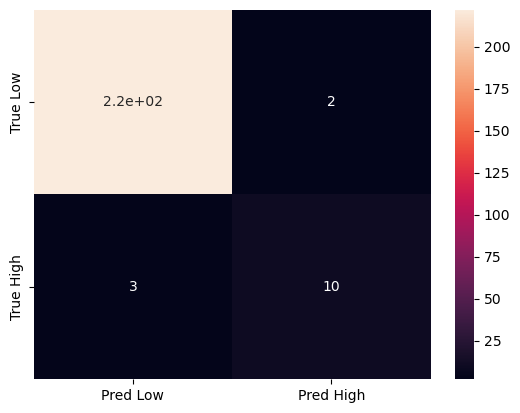

In [31]:

# Create an instance of the XGBClassifier 
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

# Compute metrics
metrics = {"f1_score": f1_score(y_test, y_pred_test, average='macro')}
print(metrics)

# Confusion matrix
results = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
df_cm = pd.DataFrame(results, ['True Low', 'True High'], ['Pred Low', 'Pred High'])
cm = sns.heatmap(df_cm, annot=True)
cm.get_figure().show()
